In [ ]:
%pip install numpy pandas matplotlib pillow opencv-python

In [ ]:
# OpenMMLab installer
%pip install -U openmim

In [ ]:
!mim --version

# Install OpenMMLab stack
!mim install mmcv
!mim install mmdet
!mim install mmrotate

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os
import cv2
import math
import xml.etree.ElementTree as X
import time

In [ ]:
import sys, os
import torch
import mmcv, mmdet, mmrotate

print("Executable:", sys.executable)
print("Venv:", os.environ.get("VIRTUAL_ENV"))

print("mmcv:", mmcv.__version__)
print("mmdet:", mmdet.__version__)
print("mmrotate:", mmrotate.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print("MMCV ops compiling cuda:", get_compiling_cuda_version())
print("MMCV ops compiler:", get_compiler_version())

In [3]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset

@ROTATED_DATASETS.register_module()
class TinyDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('RI', 'RM', 'RR', 'RL', 'LI', 'LM', 'LR', 'LL', 'RT', 'LT',)

In [ ]:
# Clone only if missing
if not os.path.isdir("mmrotate"):
    print("cloning")
    !git clone https://github.com/open-mmlab/mmrotate.git
else:
    print(f"repo already exists, skipping clone")

cwd = os.getcwd()
if os.path.basename(cwd) != "mmrotate":
    print("navigating to mmrotate")
    %cd mmrotate
else:
    print("Already in mmrotate directory")

In [ ]:
# We use mim to download the pre-trained checkpoints for inference and finetuning. (into the mmrotate directory)
ckpt_prefix = "roi_trans_swin_tiny_fpn_1x_dota_le90"
if not any(f.startswith(ckpt_prefix) and f.endswith(".py") for f in os.listdir(".")):
    print("Download pretrained checkpoint")
    !mim download mmrotate --config roi_trans_swin_tiny_fpn_1x_dota_le90 --dest .
else:
    print("Checkpoint already present")

In [ ]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from mmrotate.models import build_detector

# Choose to use a config and initialize the detector
config = 'roi_trans_swin_tiny_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'roi_trans_swin_tiny_fpn_1x_dota_le90-ddeee9ae.pth'

# Set the device to be used for evaluation
device='cpu'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

In [7]:
from mmcv import Config
cfg = Config.fromfile('./configs/roi_trans/roi_trans_swin_tiny_fpn_1x_dota_le90.py')

In [ ]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'TinyDataset'
cfg.data_root = 'ssdd_tiny/'

cfg.data.test.type = 'TinyDataset'
cfg.data.test.data_root = 'ssdd_tiny/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'TinyDataset'
cfg.data.train.data_root = 'ssdd_tiny/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'TinyDataset'
cfg.data.val.data_root = 'ssdd_tiny/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

#print(f'Config:\n{cfg.pretty_text}')
print(cfg.model.roi_head.bbox_head[1])
# modify num classes of the model in box head
cfg.model.roi_head.bbox_head[0].num_classes = 10
cfg.model.roi_head.bbox_head[1].num_classes = 10
# We can still use the pre-trained Mask RCNN model though we do not need to

# use the mask branch
cfg.load_from = 'roi_trans_swin_tiny_fpn_1x_dota_le90-ddeee9ae.pth'
# cfg.load_from = '/home/murshed/phd/git_research/ftsegment/rotated_object/transformer/mmrotate-main/demo/mmrotate/tutorial_exps/epoch_6.pth'



# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.0001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 3
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [9]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

#print(cfg.data.train)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [10]:
config_file = '../roi_trans_swin_tiny_fpn_1x_dota_le90_trained.py'
checkpoint_file = '../trained_model/transSEG.pth'

cfg = Config.fromfile(config_file)
cfg.model.roi_head.bbox_head[0].num_classes = 10
cfg.model.roi_head.bbox_head[1].num_classes = 10
model = init_detector(cfg, checkpoint_file, device='cpu')

load checkpoint from local path: ../trained_model/transSEG.pth


c:\Users\20ngu\PycharmProjects\CRFSEG\.venv\lib\site-packages\mmdet\models\dense_heads\anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


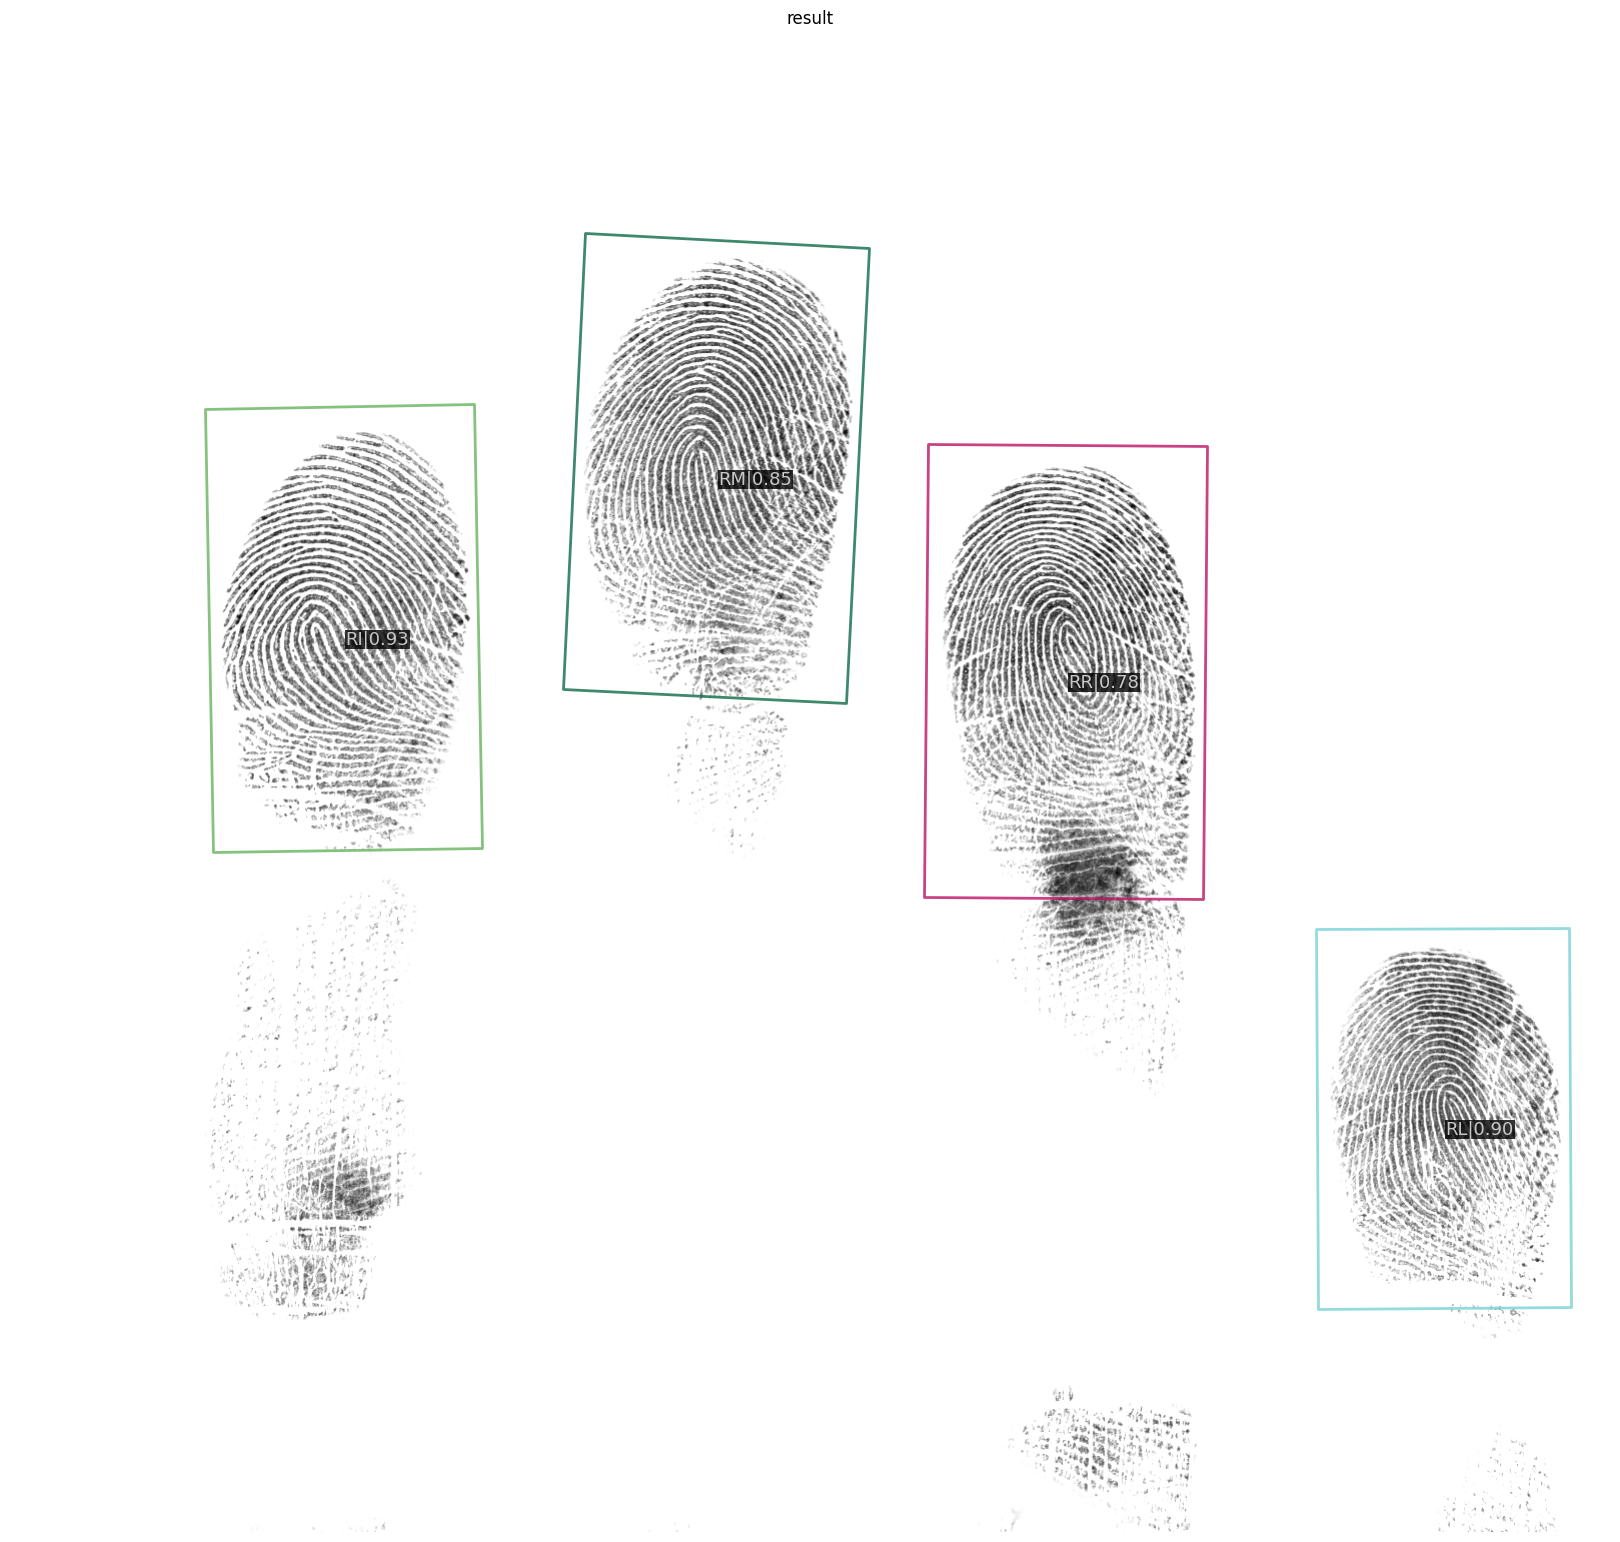

In [ ]:
import numpy as np

if not hasattr(np, "int0"):
    # Quick fix for a weird problem with numpy in the show results method
    np.int0 = np.int32

img = mmcv.imread('../../crfseg/test_image/Image_00_1_1.bmp')
model.cfg = cfg
result = inference_detector(model, img)
model.show_result
show_result_pyplot(model, img, result, score_thr=0.6)

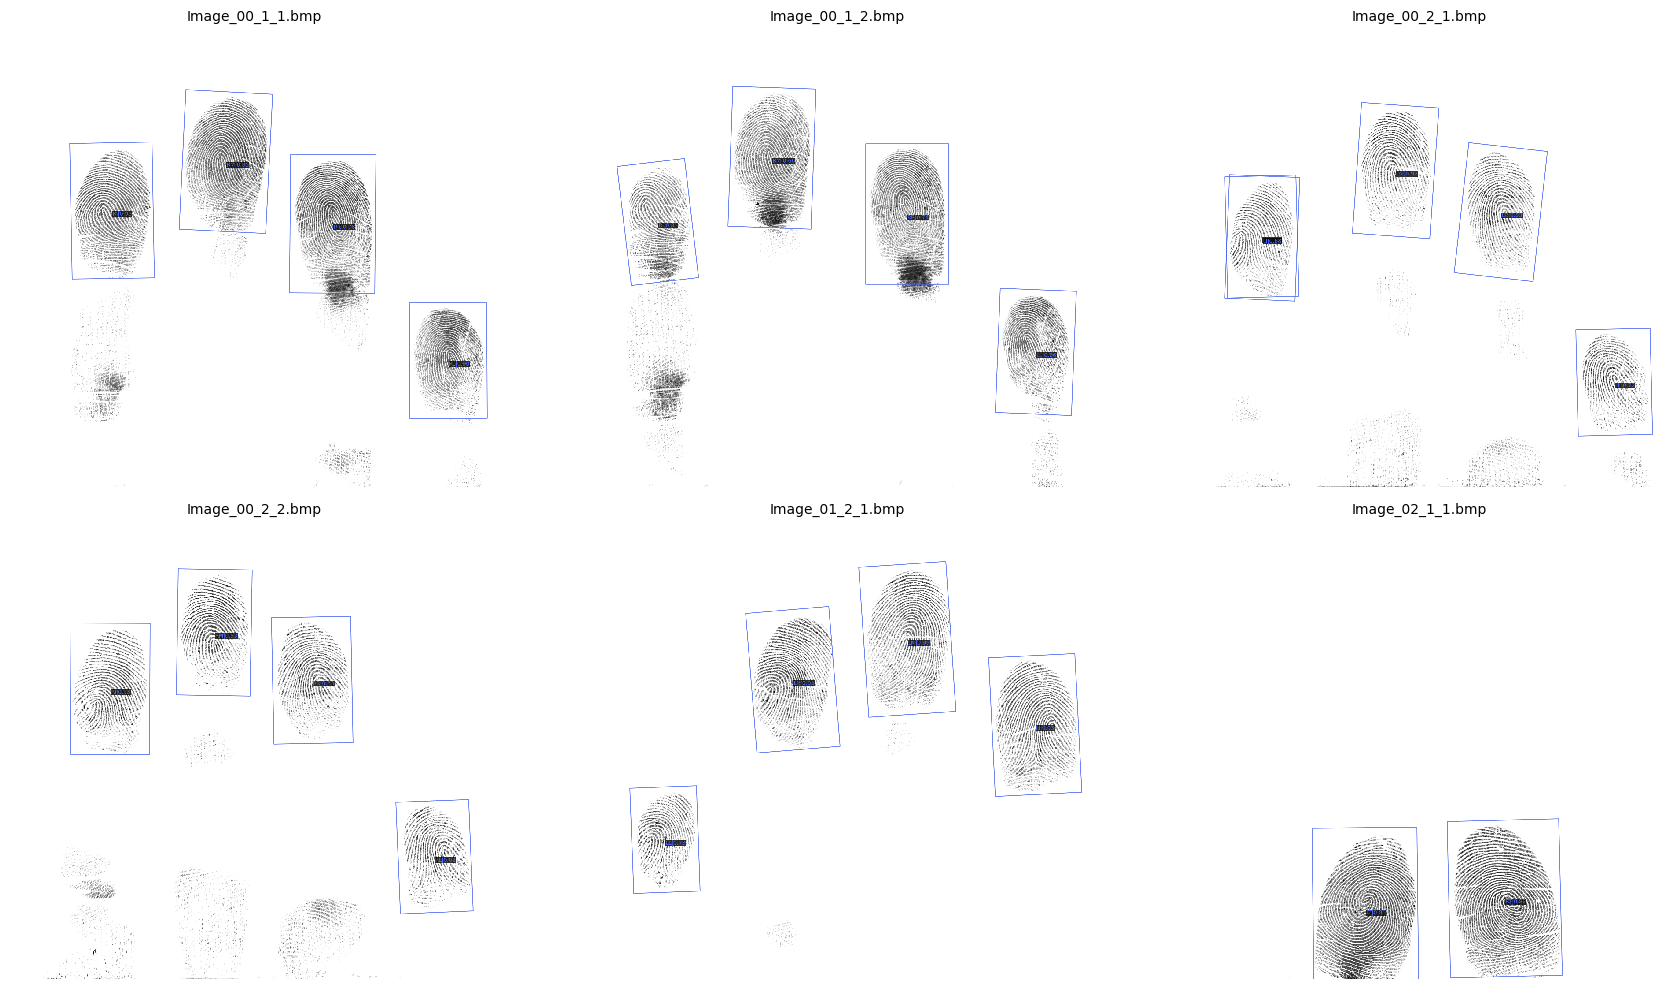

Average inference time (6 images): 2.4951 seconds


In [24]:
import os
import glob
import time
import matplotlib.pyplot as plt


if not hasattr(np, "int0"):
    np.int0 = np.int32

# Image directory
image_dir = os.path.abspath("../../crfseg/test_image")
files = sorted(glob.glob(os.path.join(image_dir, "*.bmp")))[:6]


times = []
rendered_rgbs = []
titles = []

for path in files:
    img = mmcv.imread(path)  # BGR

    start = time.perf_counter()
    result = inference_detector(model, img)
    times.append(time.perf_counter() - start)

    result_for_show = result[:len(TinyDataset.CLASSES)]

    vis = model.show_result(
        img,
        result_for_show,
        score_thr=0.6,
        show=False
    )

    if vis is None:
        vis = img
    if not isinstance(vis, np.ndarray) or vis.size == 0:
        vis = img

    if vis.ndim == 2:  # grayscale -> BGR
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
    elif vis.ndim == 3 and vis.shape[2] == 4:  # BGRA -> BGR
        vis = vis[:, :, :3]

    if vis.dtype != np.uint8:
        vmin = float(np.min(vis))
        vmax = float(np.max(vis))
        if vmin >= 0.0 and vmax <= 1.0:
            vis = (vis * 255.0).round().astype(np.uint8)
        else:
            vis = np.clip(vis, 0, 255).astype(np.uint8)


    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    rendered_rgbs.append(vis_rgb)
    titles.append(os.path.basename(path))

# Now do matplotlib ONLY once, using pre-rendered arrays
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(rendered_rgbs):
        ax.imshow(rendered_rgbs[i], interpolation="nearest")
        ax.set_title(titles[i], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

avg = sum(times) / len(times) if times else float("nan")
print(f"Average inference time ({len(times)} images): {avg:.4f} seconds")


In [13]:
import time
import glob

if not hasattr(np, "int0"):
    np.int0 = np.int32


image_dir = os.path.abspath("../../crfseg/test_image")
files = sorted(glob.glob(os.path.join(image_dir, "*.bmp")))


N_RUNS = 100

# Limits thread count to 1 to keep results as reproducible as possible
default_num_threads = torch.get_num_threads()
torch.set_num_threads(1)


# Preload images and warmup model
images = [mmcv.imread(f) for f in files]
for im in images:
    _ = inference_detector(model, im)

times = []
for i in range(N_RUNS):
    im = images[i % len(images)]
    start_time = time.perf_counter()
    _ = inference_detector(model, im)
    times.append(time.perf_counter() - start_time)

times = np.array(times)

print("CPU inference-only benchmark on one thread")
print(f"mean:   {times.mean()*1000:.2f} ms")
print(f"std:    {times.std(ddof=1)*1000:.2f} ms")

torch.set_num_threads(default_num_threads)

CPU inference-only benchmark on one thread
mean:   15389.31 ms
std:    823.30 ms
